# **Transfer Learning with Pre-Trained Tensorflow Hub Model**

In this Jupyter Notebook, we will run through the steps of building and training a model with Tensorflow [1], which will identify fake product reviews within our Amazon Database [2]. This model is developed to experiment and demonstrate the possibilities of Transfer Learning.

[1] <b>Tensorflow</b>; "An end-to-end open source machine learning platform.", https://www.tensorflow.org/   
[2] <b>Amazon Database</b>; https://www.kaggle.com/lievgarcia/amazon-reviews/

<div>
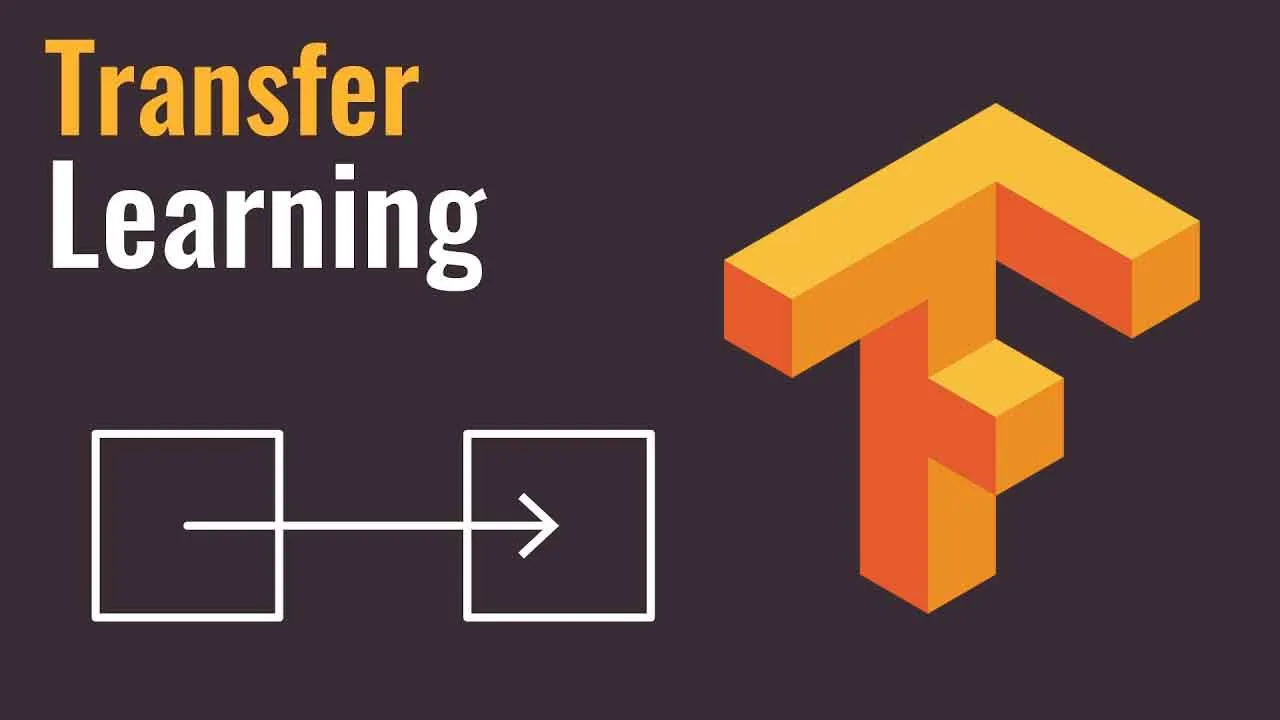
</div>

As defined by Tensorflow, Transfer Learning [1] is the process of adopting a model which was pre-trained on a larger and general dataset and customizing it (re-training) according to the problem that we are trying to solve. This way, we can take advantage of the experience that the model already gained from the larger dataset, which results in having to perform significantly less training of our own model while still gaining the functionality that we aimed to achieve.

[1] <b>Transfer Learning</b>; https://www.tensorflow.org/tutorials/images/transfer_learning

# **Importing the packages**

In [1]:
import os.path
import wget
import shutil

import numpy as np
import pandas as pd

# Expands English contractions in Text (I'd -> I would)
# https://pypi.org/project/contractions/
import contractions

import re  # library enabling the use of REGEX Operations to filter unwanted characters

import tensorflow as tf

import tensorflow.keras as keras
import tensorflow_hub as hub

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# **Data Analysis and pre-processing**

*Assumption:* We use pandas to read the data. Our text file is 'tab' delimited. Hence we use *delimiter=\t* in the read_csv() of pandas. Some rows of the data has missing columns. We want to remove these columns during preprocessing. Hence we have the argument *error_bad_lines=False* which will make sure some of the rows with missing values will not be read. 

In [2]:
if not os.path.isfile('amazon_reviews.txt'): # downloads db to train if it does not exist in the directory
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download' # db to train
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')
    print('Done!')

train_df = pd.read_csv('amazon_reviews.txt', delimiter='\t', error_bad_lines=False)

Download Completed!
Unzipping...
Done!


**Analyse the data** <br/>
We use the head() of the pandas package to see what our data looks like.

In [3]:
train_df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


We observe that the 'LABEL' column is Categorical. In order to use this dataset to work with Deep learning models, we need to convert these Categorical values to numerical values.

In [4]:
# Converting categorical 'LABEL' values to numerical

train_df['LABEL'] = pd.Categorical(train_df['LABEL'])
train_df['LABEL'] = train_df['LABEL'].cat.codes

# Text Cleaning

The following methods were used to clean the text within the dataset;
* <b>Lowercasing</b> all characters.
* <b>Contractions Library</b> which automatically expands English Contractions in Text (I'd -> I would) 
* <b>REGEX Rules</b> to remove irrelevant characters.

Reference: https://github.com/haresrv/Case-Study_Fake-Product-Review-Monitoring-and-Removal

In [5]:
def preprocess(text):  # Data Preprocessing
    text = str(text)
    text = text.lower()  # All text must be converted to lowercase to reduce duplicate detection and processing of the
    # same word
    text = contractions.fix(text)  # Expands all English contractions to reduce duplicate detection and processing of
    # the same expression (who's -> who is)

    # Filtering unwanted characters via Regular Expressions
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r"\s+[a-z]\s+", " ", text)
    text = re.sub(r"^[a-z]\s+", " ", text)
    text = re.sub(r"\s+[a-z]$", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text

Executing preprocess function over the 'REVIEW_TEXT' Column.

In [6]:
train_df["REVIEW_TEXT"] = train_df['REVIEW_TEXT'].apply(lambda x: preprocess(x))

Dropping irrevelant feature columns such as 'DOC_ID', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY', 'PRODUCT_ID', 'PRODUCT_TITLE', 'REVIEW_TITLE'

In [7]:
features = ["REVIEW_TEXT", "LABEL"]


train_shortened_df = train_df[features]

# Analysing the data
We use the head() of the pandas package to see what our data looks like. From this data we can see that 'LABEL' is the column we are trying to predict. To predict this value we make use of different features from the data. 
The different features we are using are 'REVIEW_TEXT' and 'LABEL'.

In [8]:
train_shortened_df.head()

,REVIEW_TEXT,LABEL
0,when least you think so this product will save...,0
1,lithium batteries are something new introduced...,0
2,purchased this swing for my baby she is month...,0
3,was looking for an inexpensive desk calcolatu...,0
4,only use it twice week and the results are gr...,0


We are now introduced to a simpler dataset with the 'LABEL' Column converted from Categorical to Numerical values.

# Training, Validation and Test set Splitting and Data Shuffling

We have the data to work with and we need to into split it into three parts; training, validation and test sets. We train our model on the training set, tune our hyperparameters on the validation set and finally evaluate the model on the test set. We split the data into 80% training set, 10% validation set and 10% test set.

Shuffling the data is a must, since the training and validation sets should have both of the labels. This is crucial for an efficient training and is automatically done by the 'train_test_split' function of the <b>Sklearn Library</b>.

In [9]:
x_train, x_testval, y_train, y_testval = train_test_split(train_shortened_df[['REVIEW_TEXT']], train_shortened_df[['LABEL']] , test_size = 0.20)
x_test, x_val, y_test, y_val = train_test_split(x_testval[['REVIEW_TEXT']], y_testval[['LABEL']] , test_size = 0.50)

# Building the model

In [10]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2" # pre-trained Tensoflow Hub Model

# trainable=False means we have frozen the weights of the pre-trained model, no training will happen on these weights for now
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False) 

model_classifier = tf.keras.Sequential()
model_classifier.add(hub_layer)  # Adding pre-trained Tensorflow Hub Model to our own model

model_classifier.add(Dense(16, activation='relu'))

# 1D outputting final layer with Sigmoid Activation Function to predict Fake Reviews (LABEL) in a Binary Fashion
model_classifier.add(Dense(1, activation='sigmoid'))

The model is compiled using the ADAM optimizer and Binary Cross Entropy loss.

In [11]:
model_classifier.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])

In [12]:
model_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


# Training the Model

In [13]:
history_frozen_weights = model_classifier.fit(x_train,
                            y_train,
                            epochs=60,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1)

model_classifier.save("fakeReviewDetector_frozen_weights.hdf5")

Epoch 1/60
525/525 [==============================] - 2s 4ms/step - loss: 0.6757 - acc: 0.5758 - val_loss: 0.6641 - val_acc: 0.5914
Epoch 2/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6594 - acc: 0.5978 - val_loss: 0.6577 - val_acc: 0.6043
Epoch 3/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6555 - acc: 0.6033 - val_loss: 0.6570 - val_acc: 0.6000
Epoch 4/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6532 - acc: 0.6093 - val_loss: 0.6531 - val_acc: 0.6157
Epoch 5/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6513 - acc: 0.6126 - val_loss: 0.6507 - val_acc: 0.6129
Epoch 6/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6497 - acc: 0.6156 - val_loss: 0.6491 - val_acc: 0.6210
Epoch 7/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6477 - acc: 0.6179 - val_loss: 0.6464 - val_acc: 0.6229
Epoch 8/60
525/525 [==============================] - 2s 3ms/step - loss: 0.

Final evaluation of the performance of the Model on the <b>unseen</b> test dataset.

In [14]:
results = model_classifier.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results[1]} ')

66/66 [==============================] - 0s 4ms/step - loss: 0.6525 - acc: 0.6100
Evaluation on all data has accuracy of: 0.6100000143051147 


# Visualizing the results

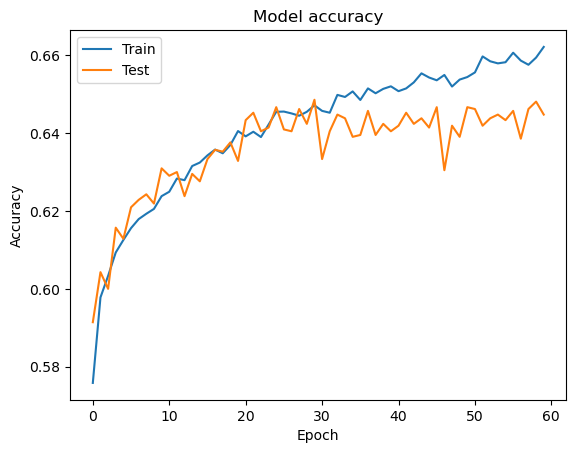

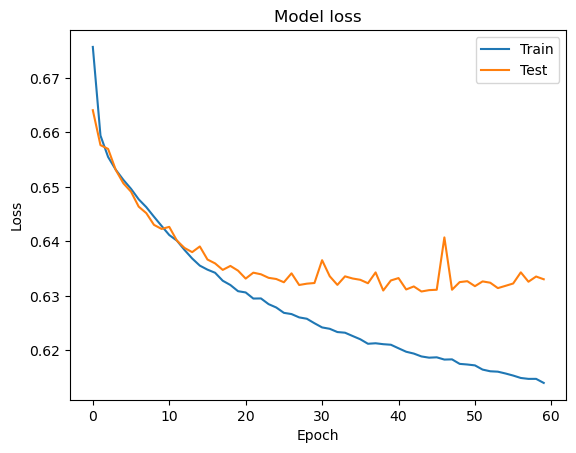

In [27]:
plt.plot(history_frozen_weights.history['acc'])
plt.plot(history_frozen_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_frozen_weights.history['loss'])
plt.plot(history_frozen_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Underfitting

Coming up to a simple definition for <b>Underfitting</b>, it is the behaviour of a model under training that does not fully train over the dataset. It can easily be detected by observing the training loss metric of the model, which does not converge near 0.01 as was mentioned at the <i>Applied Deep Learning for NLP Seminar</i> at the Technical University of Munich.

# Evaluating the Training Result

* The issue with the metrics above is that even after performing training for 60 epochs, the loss metric of the training dataset actually does not converge near 0.01 as well as its accuracy not converging near 0.99. This problem is related to the <b>capacity (number of trainable weights)</b> of our model. If we once again observe the summary of our model created with the command <i>model_classifier.summary()</i> above, it is seen that the number of trainable parameters of our model is 833, which seems to be not enough to handle our dataset. This issue is referred to as the problem of "<b>Underfitting</b>", and can clearly be identified from the graphs above by observing that the training loss does not converge to 0.01 but rather stays at about 0.60.

<hr>

# Solution 1 - Preventing Underfitting by performing Fine Tuning to Increase the Capacity of the Model

In [16]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)


model_classifier_weights_unfrozen = tf.keras.Sequential()
model_classifier_weights_unfrozen.add(hub_layer)  # Transfer Learning for pre-trained word embeddings

model_classifier_weights_unfrozen.add(Dense(16, activation='relu'))
model_classifier_weights_unfrozen.add(Dense(1, activation='sigmoid'))

In [17]:
model_classifier_weights_unfrozen.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])

In [18]:
model_classifier_weights_unfrozen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_unfrozen_weights = model_classifier_weights_unfrozen.fit(x_train,
                            y_train,
                            epochs=30,
                            batch_size=256,
                            validation_data=(x_val, y_val),
                            verbose=1)

model_classifier_weights_unfrozen.save("fakeReviewDetector_unfrozen_weights.hdf5")

Epoch 1/30
66/66 [==============================] - 5s 70ms/step - loss: 0.6790 - acc: 0.5649 - val_loss: 0.6515 - val_acc: 0.6324
Epoch 2/30
66/66 [==============================] - 4s 68ms/step - loss: 0.6239 - acc: 0.6568 - val_loss: 0.6212 - val_acc: 0.6481
Epoch 3/30
66/66 [==============================] - 5s 68ms/step - loss: 0.5675 - acc: 0.7084 - val_loss: 0.6114 - val_acc: 0.6648
Epoch 4/30
66/66 [==============================] - 5s 68ms/step - loss: 0.5082 - acc: 0.7524 - val_loss: 0.6201 - val_acc: 0.6676
Epoch 5/30
66/66 [==============================] - 4s 68ms/step - loss: 0.4483 - acc: 0.7952 - val_loss: 0.6492 - val_acc: 0.6586
Epoch 6/30
66/66 [==============================] - 4s 68ms/step - loss: 0.3928 - acc: 0.8286 - val_loss: 0.6851 - val_acc: 0.6495
Epoch 7/30
66/66 [==============================] - 4s 68ms/step - loss: 0.3425 - acc: 0.8558 - val_loss: 0.7353 - val_acc: 0.6448
Epoch 8/30
66/66 [==============================] - 5s 68ms/step - loss: 0.2973 - a

Final evaluation of the performance of the Model on the unseen test dataset.

In [20]:
results_unfrozen = model_classifier_weights_unfrozen.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results_unfrozen[1]} ')

66/66 [==============================] - 0s 3ms/step - loss: 2.6006 - acc: 0.6052
Evaluation on all data has accuracy of: 0.6052380800247192 


# Visualizing the results

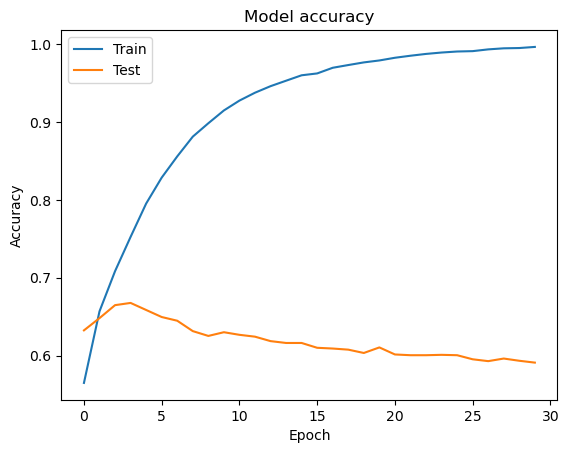

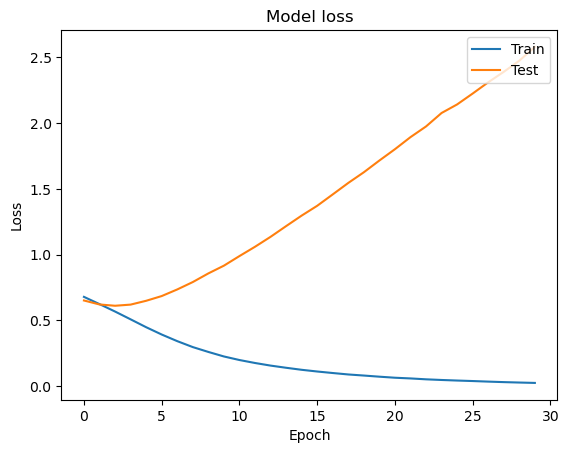

In [21]:
plt.plot(history_unfrozen_weights.history['acc'])
plt.plot(history_unfrozen_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_unfrozen_weights.history['loss'])
plt.plot(history_unfrozen_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Overfitting

Coming up to a simple definition for <b>Overfitting</b>, it is the behaviour of a model under training that memorizes the training dataset introduced to it, as was mentioned at the <i>Applied Deep Learning for NLP Seminar</i> at the Technical University of Munich. The main characteristic behavior one can use to detect this problem is when the training loss is continuously decreasing and converging to 0.01 but the validation accuracy has no improvements and if not prevented will start to even increase in the upcoming epochs.

# Evaluating the Training Result

* We will once again observe the number of our trainable parameters like we have previously done so. When the command <i>model_classifier.summary()</i> is executed above, it is seen that our current model now has a total of 48,191,433 <b>Trainable Parameters</b>. As an expected behaviour, our training loss has converged near 0.01, meaning that it has been trained to the maximum extend. With this approach, the problem of <b>Underfitting</b> has been solved.

* From the Training Logs and the two graphs above, it can be clearly seen that after some epochs the accuracy and the loss values of the training and test set differentiate from each other. Even though the loss of the training set converges to 0.01, the training metrics of the validation set are not improving. This is a serious problem because it indicates that the model simply memorized the training set and will not generate successful predictions over unseen data. The problem we are facing in such situation is called "<b>Overfitting</b>".



<hr>

# Solution 2 - Preventing Overfitting by using Early Stopping

In order to prevent the problem of overfitting and coming up to a better training, we will now apply an approach called the "<b>Early Stopping</b>". Tensorflow already implements this feature and allows us to use it via the help of callbacks that are provided to the fit function, which is used to start the traing of the model.

While defining our callbacks array, we have asked Tensorflow to monitor the validation loss for the process and to restore to the best combination of weights that were ever reached during training. When Tensorflow monitors the validation loss as a metric for Early Stopping, it will terminate the training process after a pre-defined number of epocs where the validation loss was not able to be improved. This pre-defined number is included in the process through the "<b>patience</b>" parameter.

In [22]:
# The same model is re-defined to prevent the training from continuing on top of the process previously achieved 

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

model_classifier_weights_frozen_earlyStopping = tf.keras.Sequential()
model_classifier_weights_frozen_earlyStopping.add(hub_layer)  # Transfer Learning for pre-trained word embeddings
model_classifier_weights_frozen_earlyStopping.add(Dense(16, activation='relu'))
model_classifier_weights_frozen_earlyStopping.add(Dense(1, activation='sigmoid'))

model_classifier_weights_frozen_earlyStopping.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])


callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
                                        verbose=1, mode="min", restore_best_weights=True)
]
    
history_frozen_weights_early_stopping = model_classifier_weights_frozen_earlyStopping.fit(x_train,
                            y_train,
                            epochs=60,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=callbacks)

model_classifier_weights_frozen_earlyStopping.save("fakeReviewDetector_frozen_weights_earlyStopping.hdf5")

Epoch 1/60
525/525 [==============================] - 34s 65ms/step - loss: 0.6442 - acc: 0.6132 - val_loss: 0.6110 - val_acc: 0.6605
Epoch 2/60
525/525 [==============================] - 34s 65ms/step - loss: 0.5390 - acc: 0.7253 - val_loss: 0.6230 - val_acc: 0.6586
Epoch 3/60
525/525 [==============================] - 34s 65ms/step - loss: 0.4374 - acc: 0.7948 - val_loss: 0.6765 - val_acc: 0.6371
Epoch 00003: early stopping


In [23]:
results = model_classifier_weights_frozen_earlyStopping.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results[1]} ')

66/66 [==============================] - 0s 3ms/step - loss: 0.6049 - acc: 0.6600
Evaluation on all data has accuracy of: 0.6600000262260437 


# Visualizing the results

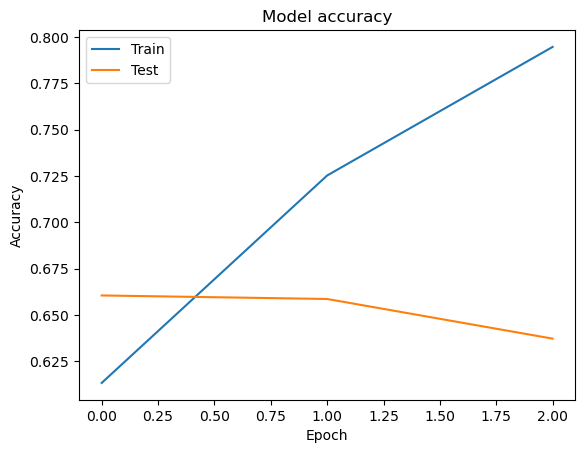

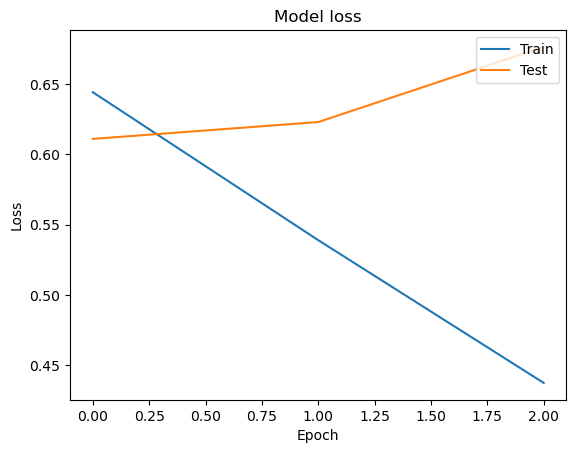

In [24]:
plt.plot(history_frozen_weights_early_stopping.history['acc'])
plt.plot(history_frozen_weights_early_stopping.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_frozen_weights_early_stopping.history['loss'])
plt.plot(history_frozen_weights_early_stopping.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluating the Training Result


Even though we used <b>Early Stopping</b>, it was unfortunately not enough to prevent overfitting. The reason for this is that this time our model has about 60 times more trainable parameters than it used to have before, meaning that the model's capacity overcomes the size of our database. In order to prevent this, the following approaches can be taken;

* Reducing the capacity of the model by using methods such as <b>Dropout</b>.
* Switching to a similar but larger dataset.

<hr>

# Solution 3 - Reducing the Capacity of the Model

Since in our model we have imported a pre-trained Tensorflow Hub model to perform Transfer Learning and almost all of our trainable parameters come directly from the imported model, we are unable to perform capacity reduction on the model. One thing that could have been done was to adopt a simpler pre-trained model from Tensorflow Hub. However as can be seen from the link [1], the model that we have choosen was already the lightest one available.

[1] https://tfhub.dev/s?fine-tunable=yes&module-type=text-embedding&q=Token%20based%20text%20embedding%20trained

# Solution 4 - Switching to a more complex Pipeline

Coming up to the maximum possibilities this pipeline could offer, we have decided to experiment other different models and pipelines widely used by NLP Enthusiasts like BiLSTM, Word2Vec and so on. These approaches are found within the following notebooks.

<hr>